This script quantifies non-additive effects as in PMID 25897392.

In [1]:
import pandas, numpy, matplotlib_venn

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40, 'svg.fonttype':'none'})

# 0. user-defined variables

In [3]:
expression_file = '/home/adrian/projects/nautholsvik/results/tpm/DESeq2_TPM_values.tsv'
significance_dir = '/home/adrian/projects/nautholsvik/results/DEGs_DESeq2/'
annotation_file = '/home/adrian/projects/nautholsvik/results/annotation/annotation.csv'

expression_figures_dir = '/home/adrian/projects/nautholsvik/results/non-additive/'

In [4]:
genotypes = ['siCTRL', 'siMITF']
treatments = ['wo_IFN', 'with_IFN']

# 1. read annotation

In [5]:
raw = {}
with open(annotation_file, 'r') as f:
    header = f.readline()
    for line in f:
        v = line.split(',')
        v = [element.replace('"', '') for element in v]
        v[-1] = v[-1].replace('\n', '')
        
        gene_name = ''
        ensembl = v[2]
        gene_name = v[3]
        description = v[4].split('[Source')[0]
        if gene_name == '':
            gene_name = ensembl
            
        #if ensembl == 'ENSG00000096150':
        #    print(v)
            
        raw[ensembl] = [gene_name, description]
        
# create a dataframe
df = pandas.DataFrame.from_dict(raw)
annotation = df.transpose()
annotation.columns = ['gene_name', 'description']
print(annotation.shape)

(68324, 2)


In [6]:
# print(annotation.loc['ENSG00000096150', ])
# print(annotation.loc['ENSG00000210049', ])

In [7]:
# annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
# annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
# annotation.drop_duplicates(inplace=True)
# print(annotation.shape)

# 2. read and manipulate expression data

In [8]:
expression_with_replicates = pandas.read_csv(expression_file, sep='\t', index_col=0)

In [9]:
plotting_df = pandas.DataFrame()
replicate_labels = expression_with_replicates.columns

for genotype in genotypes:
    for treatment in treatments:
        new_label = genotype + '_' + treatment + '_tpm'
        sub = [label for label in replicate_labels if genotype in label and treatment in label]
        df = expression_with_replicates[sub]
        plotting_df[new_label] = df.median(axis=1)

In [10]:
plotting_df['average_expression_tpm'] = plotting_df.mean(axis=1)
plotting_df['max_expression_tpm'] = plotting_df.max(axis=1)

plotting_df['geneID'] = annotation['gene_name']
plotting_df['description'] = annotation['description']

print(plotting_df.shape)
plotting_df.head()

(40173, 8)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD,tenomodulin
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112


# 3. add fold-changes of each independent effect

In [11]:
plotting_df['A1A0_log2fc'] = numpy.log2(plotting_df['siCTRL_with_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)
plotting_df['B0A0_log2fc'] = numpy.log2(plotting_df['siMITF_wo_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)
plotting_df['B1A0_log2fc'] = numpy.log2(plotting_df['siMITF_with_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,B1A0_log2fc
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295,-0.070067
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD,tenomodulin,0.000000,0.000000,0.000000
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731,0.073612
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401,0.787565
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281,-0.904026


# 4. read fold changes and P values from DESeq2

In [12]:
# read signifcances
df = pandas.read_csv(significance_dir+'A0_A1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_A1A0'] = df['padj']

df = pandas.read_csv(significance_dir+'A0_B0_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B0A0'] = df['padj']

df = pandas.read_csv(significance_dir+'A0_B1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B1A0'] = df['padj']

df = pandas.read_csv(significance_dir+'interaction.tsv', sep='\t', index_col=0)
plotting_df['P_interaction'] = df['padj']

In [13]:
# making sure that P values are also below 0.05. Checking on a large set
df = pandas.read_csv(significance_dir+'A0_B1_transition.tsv', sep='\t', index_col=0)
print(df.shape)
new = df[df['padj'] < 0.1]
numpy.max(new['pvalue'])

(8684, 6)


0.0445779276776289

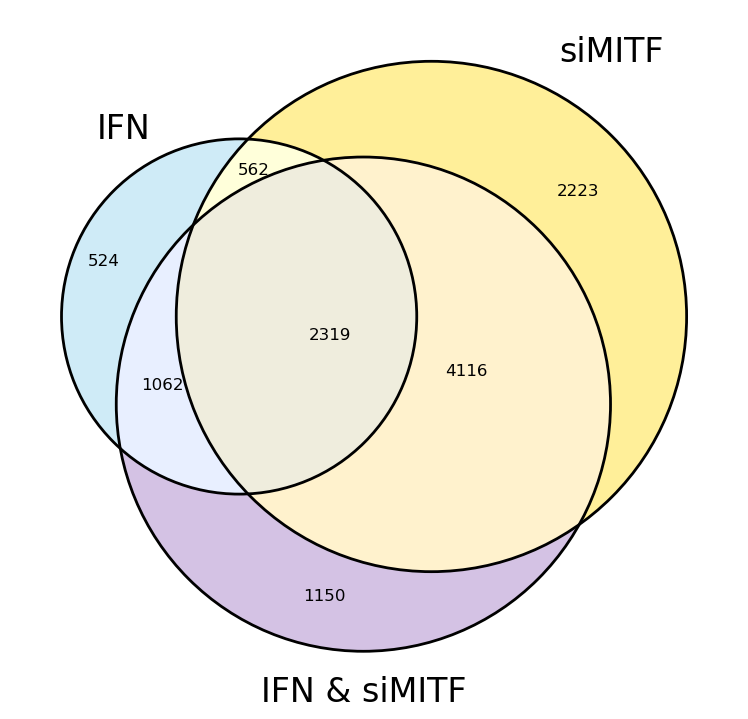

In [14]:
# generate a venn diagram before filtering for fun
set1 = set(plotting_df[plotting_df['P_A1A0'] < 0.1].index)
set2 = set(plotting_df[plotting_df['P_B0A0'] < 0.1].index)
set3 = set(plotting_df[plotting_df['P_B1A0'] < 0.1].index)

v = matplotlib_venn.venn3(
    subsets=[set1, set2, set3],
    set_labels = ('IFN', 'siMITF', 'IFN & siMITF'),
    set_colors=("skyblue", "gold", "tab:purple"),
)

matplotlib_venn.venn3_circles(
    subsets=[set1, set2, set3],
    lw=2
)
for text in v.set_labels:
    text.set_fontsize(24)
for x in range(len(v.subset_labels)):
    if v.subset_labels[x] is not None:
        v.subset_labels[x].set_fontsize(12)
matplotlib.pyplot.show()

# 5. remove element whose top expression is below 2 TPM

In [15]:
# plotting_df.fillna(1, inplace=True) # this does not seem to be necessary anymore

In [16]:
# remove low-expression genes: less than two tpm
print(plotting_df.shape)
plotting_df.drop(plotting_df[plotting_df['max_expression_tpm'] < 2].index, inplace=True)
print(plotting_df.shape)

(40173, 15)
(12742, 15)


In [17]:
plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,B1A0_log2fc,P_A1A0,P_B0A0,P_B1A0,P_interaction
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295,-0.070067,NaN,0.047938,NaN,NaN
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731,0.073612,NaN,NaN,NaN,NaN
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401,0.787565,4.013398e-06,0.000382,1.566996e-09,NaN
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281,-0.904026,4.695720e-03,0.000003,8.477960e-14,NaN
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,2.936053,1.090546e-46,0.002749,8.933908e-151,1.311356e-16


In [18]:
plotting_df.loc['ENSG00000284610', ]

siCTRL_wo_IFN_tpm                    5.648556
siCTRL_with_IFN_tpm                  3.222984
siMITF_wo_IFN_tpm                    1.713617
siMITF_with_IFN_tpm                  2.304635
average_expression_tpm               3.222448
max_expression_tpm                   5.648556
geneID                        ENSG00000284610
description               RNA binding protein
A1A0_log2fc                         -0.654778
B0A0_log2fc                         -1.292824
B1A0_log2fc                          -1.00855
P_A1A0                                0.05346
P_B0A0                               0.000103
P_B1A0                               0.000168
P_interaction                        0.028866
Name: ENSG00000284610, dtype: object

In [19]:
# these numbers is to see the effect of removing low-expressed genes, it is not represtantive of the final set of genes, specially for the interaction
# originally, at the significance level we had A1A0: 4,414; B0A0: 9,116 and interaction: 700
print(sum(plotting_df['P_A1A0'] < 0.1))
print(sum(plotting_df['P_B0A0'] < 0.1))
print(sum(plotting_df['P_interaction'] < 0.1))

3961
7688
652


In [20]:
rule_IFN = (plotting_df['P_A1A0'] < 0.1) & (numpy.abs(plotting_df['A1A0_log2fc']) > 1)
rule_MITF = (plotting_df['P_B0A0'] < 0.1) & (numpy.abs(plotting_df['B0A0_log2fc']) > 1)
rule_both = (plotting_df['P_B1A0'] < 0.1) & (numpy.abs(plotting_df['B1A0_log2fc']) > 1)

set1 = set(plotting_df[rule_IFN].index)
set2 = set(plotting_df[rule_MITF].index)
set3 = set(plotting_df[rule_both].index)

print(plotting_df[rule_IFN].shape)
print(plotting_df[rule_MITF].shape)
print(plotting_df[rule_both].shape)

(335, 15)
(778, 15)
(1129, 15)


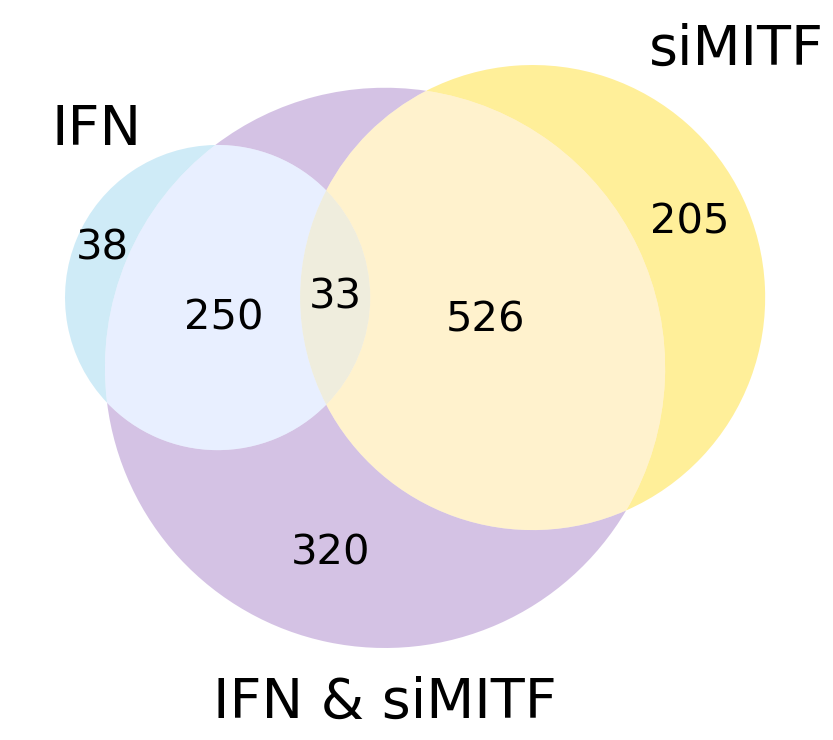

In [21]:
v = matplotlib_venn.venn3(
    subsets=[set1, set2, set3],
    set_labels = ('IFN', 'siMITF', 'IFN & siMITF'),
    set_colors=("skyblue", "gold", "tab:purple"),
)

for text in v.set_labels:
    text.set_fontsize(40)
for x in range(len(v.subset_labels)):
    if v.subset_labels[x] is not None:
        v.subset_labels[x].set_fontsize(30)
matplotlib.pyplot.show()

In [22]:
# check if MITF is A0 to B0 transition
print('ENSG00000187098' in plotting_df[plotting_df['P_B0A0'] < 0.1].index)

# check if PD-L1 is a gene with significant interaction
print('ENSG00000120217' in plotting_df[plotting_df['P_interaction'] < 0.1].index)

True
True


(778,)


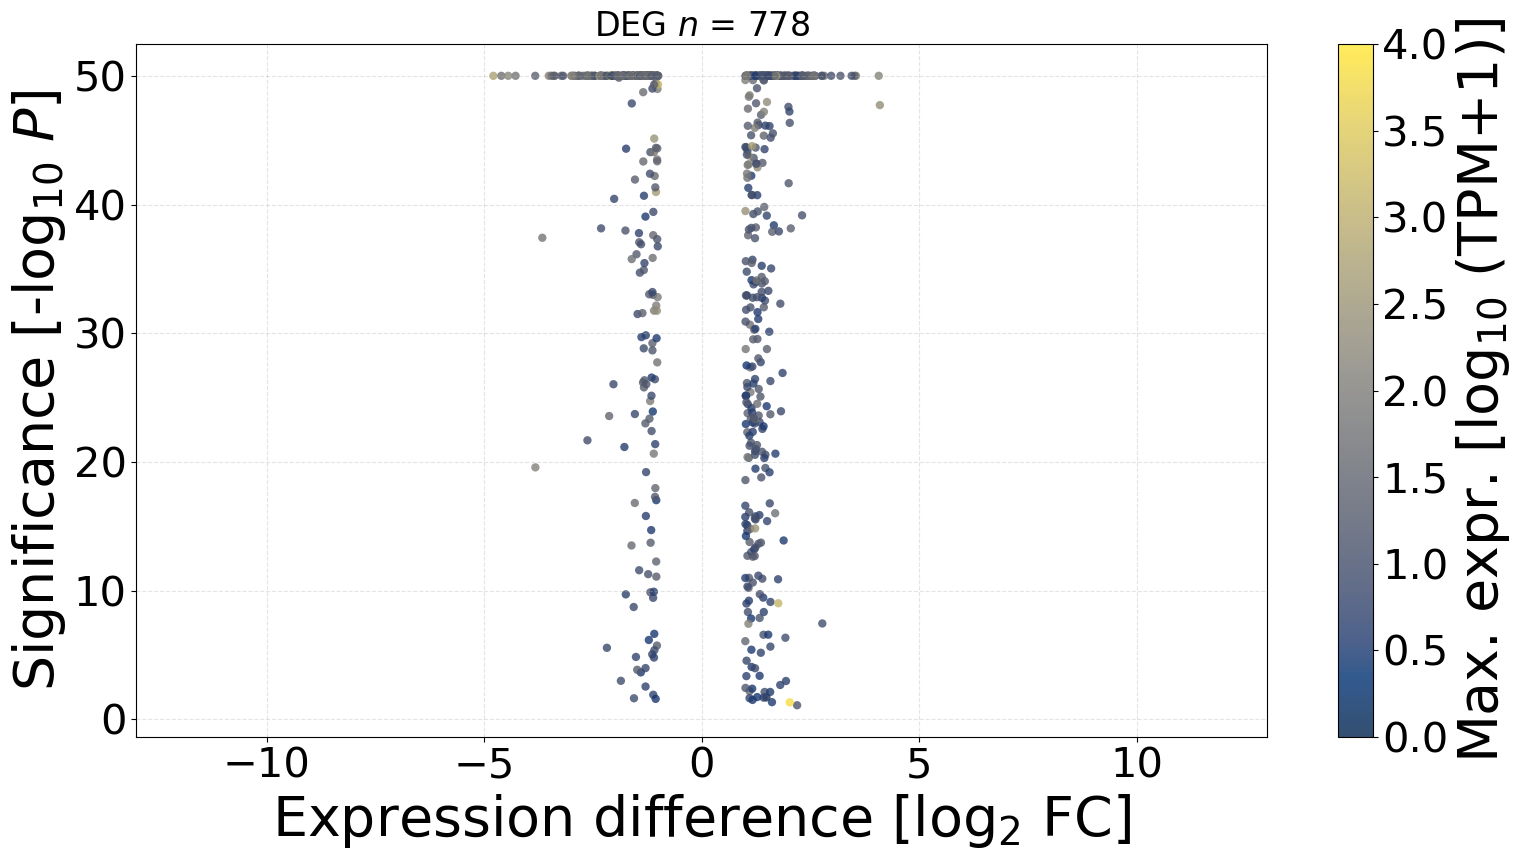

In [32]:
# doing a volcano plot for fun
x = plotting_df.loc[rule_MITF, 'B0A0_log2fc']
y = -numpy.log10(plotting_df.loc[rule_MITF, 'P_B0A0'])
y.clip(upper=50, inplace=True)
z = numpy.log10(plotting_df.loc[rule_MITF, 'max_expression_tpm']+1)
print(x.shape)

matplotlib.pyplot.scatter(x, y, c=z, alpha=0.8, edgecolors='none', cmap='cividis', vmin=0, vmax=4)
matplotlib.pyplot.colorbar(label='Max. expr. [log$_{10}$ (TPM+1)]')

matplotlib.pyplot.xlim([-13, 13])
matplotlib.pyplot.grid(ls='--', alpha = 1/3)
matplotlib.pyplot.xlabel('Expression difference [log$_2$ FC]')
matplotlib.pyplot.ylabel('Significance [-log$_{10}$ $P$]')
matplotlib.pyplot.title('DEG $n$ = 778')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# 6. add a column of the expected expression given both factors

In [ ]:
# add expected expression
deltaA = plotting_df['siCTRL_with_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
deltaB = plotting_df['siMITF_wo_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
expected = plotting_df['siCTRL_wo_IFN_tpm'] + deltaA + deltaB
plotting_df['expected'] = expected 
plotting_df.loc[plotting_df['expected'] < 0,'expected'] = 0 # avoid predicting negative expression

plotting_df.head()

# 7. determine non-linear effects at fold-change level

In [ ]:
# add log2FC observed / expected expression
non_additive = numpy.log2(plotting_df['siMITF_with_IFN_tpm']+1) - numpy.log2(plotting_df['expected']+1)
plotting_df['log2FC_observed_expected'] = non_additive

plotting_df.head()

# 8. learn type of non-additive effect

In [ ]:
plotting_df['interaction_type'] = 'not avail.'

for ensembl, row in plotting_df.iterrows():
        
    CT = plotting_df.loc[ensembl, 'siCTRL_wo_IFN_tpm']
    A = plotting_df.loc[ensembl, 'siCTRL_with_IFN_tpm']
    B = plotting_df.loc[ensembl, 'siMITF_wo_IFN_tpm']
    obs = plotting_df.loc[ensembl, 'siMITF_with_IFN_tpm']
    AB = plotting_df.loc[ensembl, 'expected']
    
    ### case (i) in Figure 2 from PMID 25897392
    if A < CT and B < CT:
        if obs > CT:
            relationship = '+S'
        elif CT > obs > AB:
            relationship = '-A'
        elif obs < AB:
            relationship = '-S'
        elif obs == AB:
            relationship = 'additive'
        else:
            print(CT, A, B, AB, obs)            
            raise ValueError('case (i) not handled')
            
    ### case (ii) in Figure 2 from PMID 25897392
    elif (A > CT and B < CT) or (A < CT and B > CT):
        if obs > numpy.max([A, B]):
            relationship = '+S'
        elif numpy.max([A, B]) > obs > AB:
            relationship = '-A'
        elif AB > obs >= numpy.min([A, B]): # the equal here is for full +A
            relationship = '+A'
        elif obs < numpy.min([A, B]):
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (ii) not handled')
    
    ### case (iii) in Figure 2 from PMID 25897392
    elif A >= CT and B >= CT:
        if obs > AB:
            relationship = '+S'
        elif AB > obs >= CT: # the equal here is bc it goes back to zero, full +A
            relationship = '+A'
        elif obs < CT:
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (iii) not handled')
    else:
        print(CT, A, B, AB, obs)
        raise ValueError('unknown case not handled')
        
    # assignment
    plotting_df.loc[ensembl, 'interaction_type'] = relationship

# 8. exploratory subsetting

In [ ]:
# expecting 222 passing log2 filter

non_additive_df = plotting_df[numpy.abs(plotting_df['log2FC_observed_expected']) > 1]
print(non_additive_df.shape)
non_additive_df.head()

In [ ]:
# expecting 66 passing both significance and log2 filters

non_additive_and_significant_df = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]

# check if PD-L1 is a gene with significant interaction (ENSG00000120217)
print('ENSG00000120217' in non_additive_and_significant_df.index)

print(non_additive_and_significant_df.shape)
non_additive_and_significant_df.head()

In [ ]:
# expecting 86 cases of more than 150% change

# border-line cases, 13 cases for 0.9 up to 1.
# if we we a threshold of 150%, then we have 86, including PD-L1
border_line = plotting_df[(plotting_df['P_interaction'] < 0.05) & (numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (numpy.abs(plotting_df['log2FC_observed_expected']) < 1)]
print('CD274' in border_line['geneID'].values)
print(border_line.shape)
border_line

In [ ]:
border_line.loc['ENSG00000120217', ] # CD274

# 9. actual subsetting

In [ ]:
# plotting set A (n = 66): log2(2) + P
# plotting set B (n = 222): log2(2)
# plotting set C (n = 152): log2(1.5) + P
# plotting set D (n = 619): log2(1.5)

plotting_setA = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setA.shape)

plotting_setB = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1)]
print(plotting_setB.shape)

plotting_setC = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setC.shape)

plotting_setD = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5))]
print(plotting_setD.shape)

# 10. plot

## 10.3. set C

In [ ]:
def figure_builder(figure_label, sub, axes_lims):
    
    sub.drop_duplicates('geneID', inplace=True)
    print(sub.shape)
    
    fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))
    
    counter = 0
    
    for ensembl, row in sub.iterrows():
        counter = counter + 1

        ### left panel
        x = sub.loc[ensembl, 'A1A0_log2fc']
        y = sub.loc[ensembl, 'B0A0_log2fc']
        z = sub.loc[ensembl, 'average_expression_tpm']
        
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        if figure_label == 'caseA':
            pass
        elif figure_label == 'caseB':
            if z > 5:
                if x < 0 or x >= 3:
                    left_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')
                if 1 <= x < 2:
                    left_panel.text(x, y+2, sub.loc[ensembl, 'geneID'], horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontstyle='italic')
                if 2 <= x < 3:
                    left_panel.text(x, y+4, sub.loc[ensembl, 'geneID'], horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontstyle='italic')
        elif figure_label == 'caseC':
            if x > 0:
                shift = 4
            else:
                shift = -2
            left_panel.text(x+shift, y, sub.loc[ensembl, 'geneID'], horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontstyle='italic')
            
        elif figure_label == 'caseD':
            left_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontstyle='italic')
        else:
            raise ValueError('error while defining text labels on left panel')
            
        ### right panel
        x = sub.loc[ensembl, 'average_expression_tpm']
        y = sub.loc[ensembl, 'log2FC_observed_expected']

        # set the color
        if sub.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif sub.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif sub.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif sub.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        ### define the size
        if numpy.abs(y) > 1:
            the_size = 300
        else:
            the_size = 100
        
        # plot
        right_panel.scatter(x, y, s=the_size, marker='o', c=the_color, alpha=2/3, edgecolor='none')

        # set the labels
        if x > 5:
            right_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')

        # print for building tables and enrichments
        #print(ensembl)
        print('{}\t{}\t{}\t{}\t{:.2f}\t{:.2f}'.format(counter, ensembl, sub.loc[ensembl, 'geneID'], sub.loc[ensembl, 'description'], x, y))
            
    # close left panel
    left_panel.set_xlim([axes_lims[0], axes_lims[1]])
    left_panel.set_ylim([axes_lims[0], axes_lims[1]])
    left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_xlabel('IFN effect [log$_2$FC]')
    left_panel.set_ylabel('siMITF effect [log$_2$FC]')
    the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
    left_panel.add_patch(the_patch)
    left_panel.grid(alpha=0.5, ls=':')
    left_panel.set_aspect('equal', 'box')
    
    # close right panel
    right_panel.set_xscale("log")
    
    right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
    right_panel.set_yticks([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
    right_panel.set_xlim([axes_lims[2], axes_lims[3]])
    right_panel.set_ylim([axes_lims[4], axes_lims[5]])
    right_panel.set_xlabel('Average expression [TPM]')
    right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
    right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
    right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:red', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:green', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:blue', markersize=20, alpha=2/3)
    ]
    right_panel.legend(legend_elements, ['+S', '+A', '-A', '-S'], loc=4)
    right_panel.grid(alpha=0.5, ls=':')   

    matplotlib.pyplot.tight_layout()
    #matplotlib.pyplot.show()
    
    matplotlib.pyplot.savefig(figure_label+'.svg')
    
    # last print
    print('number of genes in the figure: {}'.format(counter))
    print()    
    
    return None

###
### define general limits
###

axes_lims = [-3.8, 8.4, 0.6, 2900, -6.2, 6.2]

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))
print('')

## case of non-additive effects when nothing observed upon single factor
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) < 1)]
figure_builder('caseA', sub, axes_lims)

## case IFN-only effect
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) < 1)]
figure_builder('caseB', sub, axes_lims)

### case siMITF-only effect
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) > 1)]
figure_builder('caseC', sub, axes_lims)

#! case both IFN and siMITF effect
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) > 1)]
figure_builder('caseD', sub, axes_lims)